## Семинар 2 "Распознавание рукописных цифр"

ФИО: 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from sklearn.utils import shuffle
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.transform import rotate as rotation

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

base_y = y
base_X = X

In [24]:
for X_test, y_test in test_loader:
    X_test = X_test.view(X_test.shape[0], -1)
    X_test = X_test.numpy() ### Converts torch.Tensor to numpy array
    y_test = y_test.numpy()
    pass

In [25]:
X_test.shape[0]

16

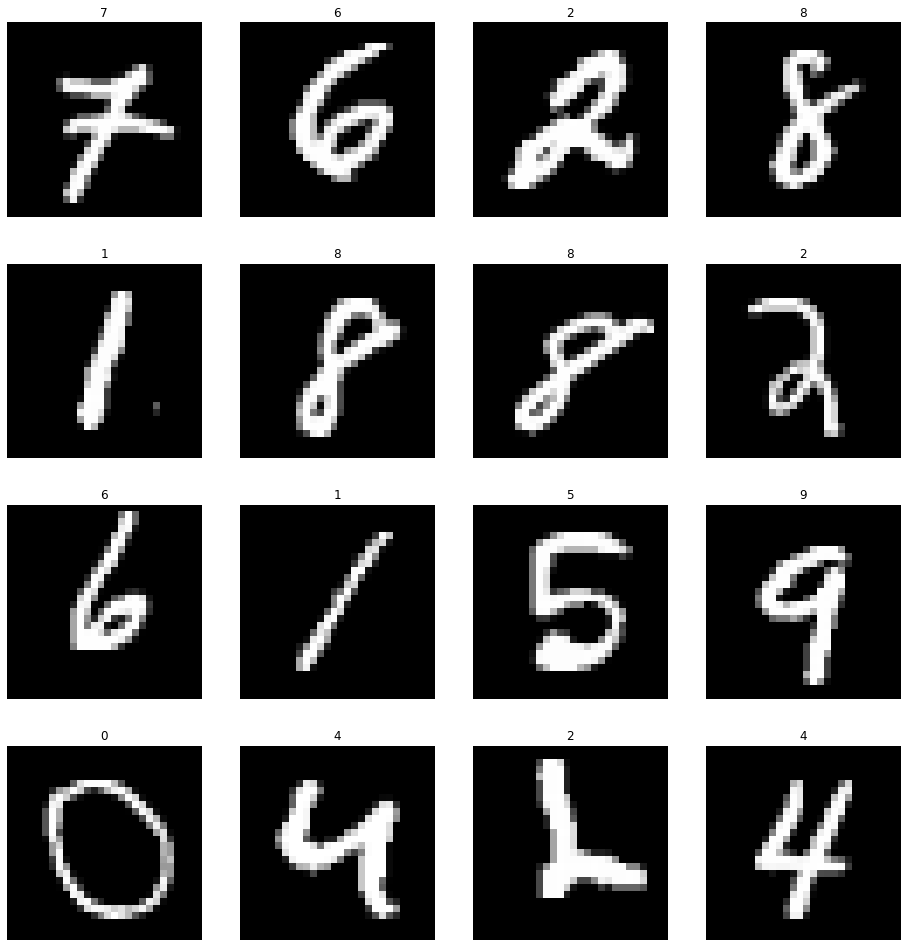

In [26]:
plt.figure(figsize=(16, 17))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [150]:
def training(NN, loss, X, y, learning_rate, 
             slowdown, epoch, show_loss=False, show_period=10):
    print("Epoch = ", epoch)
    for i in range(epoch):
        predict = NN.forward(X)
        l = loss.forward(predict, y)
        if (show_loss and i % show_period == 0):
            print("loss = ", l, "   learning_rate = ", learning_rate)
        NN.backward(loss.backward())
        NN.step(learning_rate)
        learning_rate = slowdown * learning_rate
        
def dynamic_train(NN, loss, X, y, learning_rate=0.005, baseline=0.05, threshold=50000):
    l = 1000
    epoch = 0
    while (l > baseline and epoch < threshold):
        predict = NN.forward(X)
        l = loss.forward(predict, y)
        NN.backward(loss.backward())
        NN.step(learning_rate)
        epoch += 1
    return l;
        
def predict(NN, loss, X, y):
    return loss.forward(NN.forward(X), y)

In [50]:
lin1 = Linear(784, 100)
sig1 = Sigmoid()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, sig1, lin2]
NN_sig = NeuralNetwork(modules)
learning_rate = 0.05
slowdown = 1
epoch = 300

In [51]:
training(NN_sig, loss, X, y, learning_rate, slowdown, epoch, show_loss=True)

Epoch =  300
2.3139473854878787
2.2061067337569265
2.176961152294312
2.142003007414998
2.0945720732532207
2.0298423690046548
1.9457344641366872
1.8449404456510323
1.7335112667728771
1.617050130142927
1.4990999445730024
1.3820392357402027
1.2679076411196286
1.1584115502692254
1.0547102771812265
0.9573900218368805
0.8666246507489993
0.7823830955219907
0.7045771802619368
0.6331210420147728
0.5679260350543336
0.5088686542494119
0.4557600420818929
0.4083313637754277
0.3662371808040131
0.32907164348801754
0.29639055295099165
0.26773400983883205
0.24264655863819484
0.22069322011347903


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [52]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + X * 0.01 * (X < 0) 
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * ((self.X > 0) + (self.X < 0) * 0.01)
    
    def step(self, learning_rate):
        pass

In [53]:
lin1 = Linear(784, 100)
relu1 = ReLU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, relu1, lin2]
NN_relu = NeuralNetwork(modules)
learning_rate = 0.05
slowdown = 1
epoch = 100

In [54]:
training(NN_relu, loss, X, y, learning_rate, slowdown, epoch, show_loss=True)

Epoch =  100
2.303858152978032
1.98370287030097
1.5541115549825784
0.9530507748396754
0.4622476321018106
0.2150532691012031
0.11776403603672232
0.07518023681761354
0.05319483726038943
0.040315321511845074


In [55]:
class ELU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + (np.exp(X) - 1) * (X < 0) 
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * ((self.X > 0) + np.exp(self.X) * (self.X < 0))
    
    def step(self, learning_rate):
        pass

In [56]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_elu = NeuralNetwork(modules)
learning_rate = 0.05
slowdown = 1
epoch = 100

In [57]:
training(NN_elu, loss, X, y, learning_rate, slowdown, epoch, show_loss=True)

Epoch =  100
2.296300177487035
1.8490195186029594
1.227565482242523
0.6482652923221817
0.30578524705387194
0.15738357434719202
0.09488069189862035
0.06451017854607968
0.047563840786365386
0.037070512990283105


### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

### HW1 (1 балл): Реализовать Tanh

In [58]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 2. / (1 + np.exp(-X**2)) - 1
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (-self.s**2 + 1) * dLdy
    
    def step(self, learning_rate):
        pass

In [59]:
lin1 = Linear(784, 100)
tanh1 = Tanh()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, tanh1, lin2]
NN_tanh = NeuralNetwork(modules)
learning_rate = 0.05
slowdown = 1
epoch = 100

In [60]:
training(NN_elu, loss, X, y, learning_rate, slowdown, epoch, show_loss=True)

Epoch =  100
0.030057953489972405
0.025096817234119703
0.021430216352843628
0.018625645033766288
0.016420352411763546
0.014646571742485605
0.013192697422970868
0.011981885101322868
0.010959656053021134
0.010086406252869159


### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

Аугментирование вращениями - устойчивость НС к различным поворотам изображения

In [269]:
def angle_augmentation(X, y, angle):
    boost_images = []
    boost_targets = []
    for j in range(X.shape[0]):
        sup = X[j].reshape(28, 28)
        for i in range(2 * angle // 5):
            boost_images.append(rotation(X[j].reshape(28, 28), (i * 5 - angle)).reshape(784))
            boost_targets.append(y[j])

    boost_images, boost_targets = shuffle(np.array(boost_images), np.array(boost_targets), random_state=0)
    return boost_images, boost_targets

In [311]:
boost_images, boost_targets = angle_augmentation(X, y, 15)

In [312]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_mnist = NeuralNetwork(modules)
learning_rate = 0.12
slowdown = 1
epoch = 100
show_loss = True
show_period = 10

training(NN_mnist, loss, boost_images, boost_targets, 
         learning_rate, slowdown, epoch, show_loss, show_period)

Epoch =  100
loss =  2.3069864384292402    learning_rate =  0.12
loss =  1.3450127797501004    learning_rate =  0.12
loss =  0.4351312977334098    learning_rate =  0.12
loss =  0.1609816851724808    learning_rate =  0.12
loss =  0.08235533549059809    learning_rate =  0.12
loss =  0.051671247561452804    learning_rate =  0.12
loss =  0.03643795934146021    learning_rate =  0.12
loss =  0.027633693168168008    learning_rate =  0.12
loss =  0.022005125567533645    learning_rate =  0.12
loss =  0.018142527010814702    learning_rate =  0.12


In [313]:
predict(NN_mnist, loss, X_test, y_test)

0.5526083772404473

Аугментирование шумами - устойчивость НС к случайным цветовым искажениям

In [273]:
def noise_augmentation(X, y, noise):
    boost_images = []
    boost_targets = []
    for j in range(X.shape[0]):
        boost_images.append(X[j])
        boost_images.append(X[j] + np.random.randint(-noise, noise, size=(784)) / 5000)
        boost_images.append(X[j] + np.random.randint(-noise, noise, size=(784)) / 5000)
        
        for k in range(3):
            boost_targets.append(y[j])

    boost_images, boost_targets = shuffle(np.array(boost_images), np.array(boost_targets), random_state=0)
    return boost_images, boost_targets    

In [308]:
boost_images, boost_targets = noise_augmentation(X, y, 1200)

In [309]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_mnist = NeuralNetwork(modules)
learning_rate = 0.12
slowdown = 1
epoch = 100
show_loss = True
show_period = 10

training(NN_mnist, loss, boost_images, boost_targets, 
         learning_rate, slowdown, epoch, show_loss, show_period)

Epoch =  100
loss =  2.3108139481180587    learning_rate =  0.12
loss =  1.0377453894762785    learning_rate =  0.12
loss =  0.18262053073649823    learning_rate =  0.12
loss =  0.059726322714199594    learning_rate =  0.12
loss =  0.031918167942414026    learning_rate =  0.12
loss =  0.020959415035203852    learning_rate =  0.12
loss =  0.015312920652516293    learning_rate =  0.12
loss =  0.01193179024145527    learning_rate =  0.12
loss =  0.009704398676019943    learning_rate =  0.12
loss =  0.008137234524741561    learning_rate =  0.12


In [310]:
predict(NN_mnist, loss, X_test, y_test)

0.5512403922399809

Аугментация сдвигами - устойчивость НС к различным смещениям анализируемого изображения

In [278]:
def shift_augmentation(X, y, left_shift, right_shift):
    boost_images = []
    boost_targets = []
    b = np.zeros(28, dtype = int).reshape(28, 1)
    for j in range(X.shape[0]):
        sup = X[j].reshape(28, 28)
        tmp = sup
        boost_images.append(X[j])
        
        for i in range(left_shift):
            tmp = np.column_stack((b, tmp.T[:-1:].T))
        boost_images.append(tmp.reshape(784))
        
        for i in range(right_shift):
            sup = np.column_stack((b, sup.T[:-1:].T))
        boost_images.append(sup.reshape(784))

        for k in range(3):
            boost_targets.append(y[j])

    boost_images, boost_targets = shuffle(np.array(boost_images), np.array(boost_targets), random_state=0)
    return boost_images, boost_targets  

In [284]:
boost_images, boost_targets = shift_augmentation(X, y, 2, 2)

In [285]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_mnist = NeuralNetwork(modules)
learning_rate = 0.12
slowdown = 1
epoch = 100
show_loss = True
show_period = 10

training(NN_mnist, loss, boost_images, boost_targets, 
         learning_rate, slowdown, epoch, show_loss, show_period)

Epoch =  100
loss =  2.3093973388914786    learning_rate =  0.12
loss =  1.364976624750014    learning_rate =  0.12
loss =  0.42314721665030275    learning_rate =  0.12
loss =  0.13948585372916883    learning_rate =  0.12
loss =  0.06734143018243179    learning_rate =  0.12
loss =  0.041044669865462534    learning_rate =  0.12
loss =  0.028512071820771884    learning_rate =  0.12
loss =  0.021443665239094235    learning_rate =  0.12
loss =  0.016992530197783313    learning_rate =  0.12
loss =  0.01396752139079778    learning_rate =  0.12


In [286]:
predict(NN_mnist, loss, X_test, y_test)

0.8902192647985077

Аугментация шумами и вращениями улучшает результат, в то время как сдвиги ухудшают. 

In [75]:
def augmentation(X, y, angle):
    boost_images = []
    boost_targets = []
    b = np.zeros(28, dtype = int).reshape(28, 1)

    for j in range(X.shape[0]):
        sup = X[j].reshape(28, 28)
        for i in range(2 * angle // 5):
            """
            image without augmentation
            """
            boost_images.append(X[j])
            """
            rotaion (-10, 10)
            """
            base = rotation(X[j].reshape(28, 28), (i * 5 - angle)).reshape(784)
            """
            random noises
            """
            boost_images.append(base + np.random.randint(-400, 400, size=(784)) / 5000)
            boost_images.append(base + np.random.randint(-400, 400, size=(784)) / 5000)
            """
            shifts
            """
            boost_images.append(np.column_stack((b, sup.T[:-1:].T)).reshape(784))
            boost_images.append(np.column_stack((sup.T[:-1:].T, b)).reshape(784))
        
        for k in range(2 * angle):
            boost_targets.append(y[j])

    boost_images, boost_targets = shuffle(np.array(boost_images), np.array(boost_targets), random_state=0)
    return boost_images, boost_targets    

In [76]:
boost_images, boost_targets = images_augmentation(X, y, 10)

(-0.5, 27.5, 27.5, -0.5)

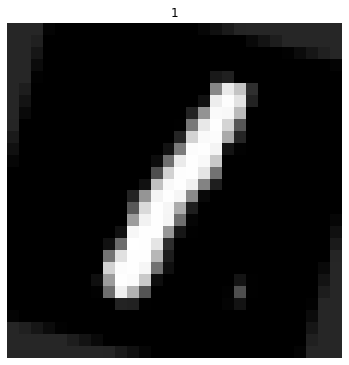

In [314]:
plt.figure(figsize=(6, 7))
plt.subplot(1, 1, 1)
plt.imshow(boost_images[46].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(boost_targets[46])
plt.axis('off')

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

# Обучение на аугментированных данных

In [241]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_mnist = NeuralNetwork(modules)
learning_rate = 0.12
slowdown = 1
epoch = 100
show_loss = True
show_period = 10

In [242]:
training(NN_mnist, loss, boost_images, boost_targets, 
         learning_rate, slowdown, epoch, show_loss, show_period)

Epoch =  100
loss =  2.2944328382788135    learning_rate =  0.12
loss =  1.1253892399486047    learning_rate =  0.12
loss =  0.26796065620491705    learning_rate =  0.12
loss =  0.09607500259407736    learning_rate =  0.12
loss =  0.05174908144907977    learning_rate =  0.12
loss =  0.033926494086758345    learning_rate =  0.12
loss =  0.024718546303611384    learning_rate =  0.12
loss =  0.019209939377118117    learning_rate =  0.12
loss =  0.015587695307910923    learning_rate =  0.12
loss =  0.013044256733379823    learning_rate =  0.12


In [243]:
predict(NN_mnist, loss, X_test, y_test)

0.5601158469399983

# Обучение на стандартных данных

In [235]:
lin1 = Linear(784, 100)
elu1 = ELU()
lin2 = Linear(100, 10)
loss = NLLLoss()
modules = [lin1, elu1, lin2]
NN_elu = NeuralNetwork(modules)
learning_rate = 0.12
slowdown = 1
show_loss = True
epoch = 100
show_period = 10

In [236]:
training(NN_elu, loss, X, y, learning_rate, slowdown, epoch, show_loss, show_period)

Epoch =  100
loss =  2.3017141091958746    learning_rate =  0.12
loss =  1.0151377739481515    learning_rate =  0.12
loss =  0.17294627830819753    learning_rate =  0.12
loss =  0.057667525573321776    learning_rate =  0.12
loss =  0.031150872059542242    learning_rate =  0.12
loss =  0.020578066313759427    learning_rate =  0.12
loss =  0.015091543687038304    learning_rate =  0.12
loss =  0.011790415135122861    learning_rate =  0.12
loss =  0.0096082003556862    learning_rate =  0.12
loss =  0.008068791707448557    learning_rate =  0.12


In [237]:
predict(NN_elu, loss, X_test, y_test)

0.6328405736458789

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Выборы нелинейности оказывают значительное влияние на сходимости сети. Как показала практика на mnist, слои ReLU и ELU сходятся быстрее чем сигмоида. При этом сигмоида обеспечивает более равномерную сходимость, что повышает точность нейронной сети на большом объёме данных. При аугментации с помощью вращения (-10, 10 градусов, на 15 получалось слишком сильное искажение), единичного сдвига картинку влева и вправо, и добавлении шума  выборка раздулась в 100 раз. При этом искажения получились всё равно получились сильные. При учёте этих фактов, нейронная сеть смогла обучиться на достаточно маленьком наборе данных и при этом стать устойчивой к разным видам искажений.

При одинаковой архитектуре нейронной сети и одинаковом выборе параметров learning_rate, epoch, НС обученная на аугментированных данных показывает на тестовой выборке результат лучше чем НС, обученная на стандартном наборе. 

НС обученные на наборе изображений, аугментированных с помощью вращений и шумов, выдают результат приблизительно такой же,
как НС обученная при использовании всех видов аугментации.